# Lab 2: Nearest Neighbour

6252320 Leon Debnath

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [46]:
# Class of k-Nearest Neigbor Classifier

class kNN():
    def __init__(self, k = 3, exp = 2, normalise=False):
        self.k = k
        self.exp = exp
        self.normalise = normalise
      
    def fit(self, X_train, Y_train):
        if self.normalise:
            self.X_train = self.normalise_data(X_train)
        else:
            self.X_train = X_train
        self.Y_train = Y_train   
         
    def getDiscreteClassification(self, X_test):
        
        if self.normalise:
            X_test = self.normalise_data(X_test)
            
        Y_pred_test = [] 
   
        for i in range(len(X_test)):   
            test_instance = X_test.iloc[i] 
            
            
            # Store distances in a dataframe. The dataframe has the index of 
            # Y_train in order to keep the correspondence with the classes
            # of the training instances 
            distances = []  
            
            for j in range(len(self.X_train)):  
                train_instance = self.X_train.iloc[j]  
                distance = self.Minkowski_distance(test_instance, 
                                                   train_instance) 
                distances.append(distance) 
        

            df_dists = pd.DataFrame(data=distances, 
                                    columns=['dist'], 
                                    index = self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the
            # new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            # Note that the index df_knn.index of df_knn contains indices 
            # in Y_train of the k-closed training instances to the i-th test
            # instance. Thus, the dataframe self.Y_train[df_knn.index] 
            # contains the classes of those k-closed training instances. 
            # Method value_counts() computes the counts (no. occurencies)
            # for each class in self.Y_train[df_knn.index] in predictions. 
            predictions = self.Y_train[df_knn.index].value_counts()
                 
            # the first element of the index predictions.index contains the
            # class with the highest count; i.e. the prediction y_pred_test.
            y_pred_test = predictions.index[0]

            # add the prediction y_pred_test to the prediction vector 
            # Y_pred_test for all the test instances in X_test
            Y_pred_test.append(y_pred_test)
        
        return Y_pred_test

    
    def Minkowski_distance(self, x1, x2):
        ''' 
        Computes the Minkowski distance of x1 and x2 for two 
        labeled instances (x1,y1) and (x2,y2) 
        '''
        distance = 0
    
        for i in range(len(x1)):
            distance = distance + abs(x1[i] - x2[i])**self.exp
        
        distance = distance**(1/self.exp)
    
        return distance

    
    #########
    # PART B
    #########
    def normalise_data(self, X) -> pd.DataFrame:
        ''' 
        NB:  this has been put INSIDE the class becuase that is what is 
        specified in the lab spec. I believe his would probably provide
        more accurate results if the entire dataset was normalised outside
        of the class and then split into a train/test split. 
        '''
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        return pd.DataFrame(X_scaled)
    
    
    #########
    # PART C
    #########
    def get_class_probs(self, X_test) -> pd.DataFrame:
        
        class_probs, columns = self.create_probs(X_test)
        
        for i in range(len(X_test)):
            test_instance = X_test.iloc[i]
            distances = []
    
            for j in range(len(self.X_train)):
                train_instance = self.X_train.iloc[j]
                distance = self.Minkowski_distance(test_instance, 
                                                   train_instance)  
                distances.append(distance)
            
            df_dists = pd.DataFrame(data=distances,
                                    columns=['dist'],
                                    index = self.Y_train.index)
        
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            row = self.set_probs(self.Y_train[df_knn.index].value_counts(),
                                 columns)
            class_probs.loc[i] = row
        
        return class_probs
            

    def create_probs(self, X_test):
        ''' 
        Create a new dataframe that holds all of the values for the 
        number of instances per column
        ''' 
        class_columns = []
        classes = self.Y_train.value_counts()
        
        for index, value in classes.items():
            class_columns.append(index)
            class_probs = pd.DataFrame(columns=class_columns)
            
        return class_probs, class_columns
    

    def set_probs(self, classifications, columns):
        ''' Set the probabilities for each classification in the row ''' 
        row = [0]*len(columns)
        
        for classification, count in classifications.items():
            
            for column in columns:
                index = columns.index(classification)
                row[index] = count / self.k
                
        return row
    
    #########
    # PART D
    #########
    def get_predictions(self, X) -> pd.DataFrame:
        '''
        For every row in the DataFrame, get the classification 
        probabilities and compute the regression cost for each element
        ''' 
        predictions = pd.DataFrame(columns = ['Reg Price'])
        class_probs = self.get_class_probs(X)
        
        for i in class_probs.index:               
            row = class_probs.loc[i]
            cost = self.compute_cost(row)
            predictions.loc[i] = cost
                
        return predictions
    
    
    def compute_cost(self, row):
        '''
        For element in the row, compute the regression cost as 
        the cost * the probability
        ''' 
        regression_cost = 0
        
        for cost, probability in row.iteritems():
            regression_cost += cost * probability
            
        return [regression_cost]
    

#### K Experiment Method <a class="anchor" id="3"></a>

In [33]:

def k_experiment(csv_file_name, normalise=False):
    ''' 
    Runs the experiment on the datatset in the named file
    for a range of k values
    '''
    data = pd.read_csv(csv_file_name)
    data.head()
    Y = data['class']
    X = data.drop(['class'],axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

    # range for the values of parameter k for kNN
    k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

    trainAcc = np.zeros(len(k_range))
    testAcc = np.zeros(len(k_range))

    index = 0 
    for k  in  k_range:
        clf = kNN(k, normalise=normalise)
        clf.fit(X_train, Y_train)
        Y_predTrain = clf.getDiscreteClassification(X_train)
        Y_predTest = clf.getDiscreteClassification(X_test)
        trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
        testAcc[index] = accuracy_score(Y_test, Y_predTest)
        index += 1

    plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--')
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    
    if normalise:
        title = csv_file_name + ' normalised'
    else:
        title = csv_file_name + ' un-modified'
    plt.title(title)
    

#### Exp Experiment Method <a class="anchor" id="4"></a>

In [34]:
def exp_experiment(csv_file_name, normalise=False):
    ''' 
    Runs the experiment on the datatset in the named file for 
    a range of exp values
    '''

    data = pd.read_csv(csv_file_name)
    data.head()
    Y = data['class']
    X = data.drop(['class'],axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

    exp_range = [2,  100, 10000]

    trainAcc = np.zeros(len(exp_range))
    testAcc = np.zeros(len(exp_range))

    index = 0 
    for exp  in  exp_range:
        clf = kNN(k=3, exp=exp, normalise=normalise)
        clf.fit(X_train, Y_train)
        Y_predTrain = clf.getDiscreteClassification(X_train)
        Y_predTest = clf.getDiscreteClassification(X_test)
        trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
        testAcc[index] = accuracy_score(Y_test, Y_predTest)
        index += 1

    plt.plot(exp_range,trainAcc,'ro-',exp_range,testAcc,'bv--')
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.xscale('log')
    plt.xlabel('exp')
    plt.ylabel('Accuracy')
    
    if normalise:
        title = csv_file_name + ' normalised'
    else:
        title = csv_file_name + ' un-modified'
    plt.title(title)


## Part B <a class="anchor" id="5"></a>

Test  the  `kNN`  classifier  on  the  diabetis  and  glass  classification  data  sets  (see Appendix A) for the case when the data is not normalized and the case when the data is normalized. Indicate whether the training and  hold-out accuracy rates improve with normalization.  

For  testing  the  `kNN`  classifier  you  might  use  the  script  provided  in  the  Jupiter notebook.  The  script  provides  a  plot  with  training  and  hold-out  accuracy  rates  in function of parameter $k$ of the `kNN` classifier. 

Test the `kNN` classifier on the glass classification data sets the data is normalized for different  values  of  the  `exp`  parameter  of  the  Minkowski  distance.  Indicate  whether the training and  hold-out accuracy rates changes due to `exp`. For this task you might use the second testing script provided in the Jupiter note.

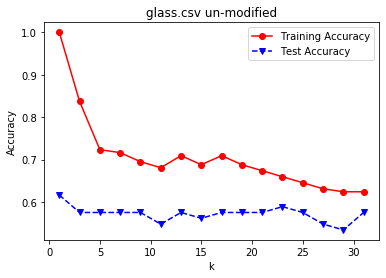

In [20]:
k_experiment('glass.csv', normalise=False)

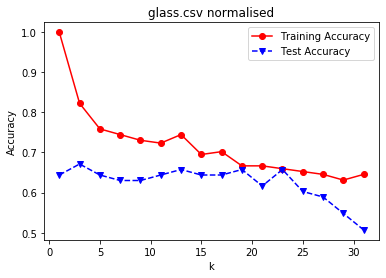

In [23]:
k_experiment('glass.csv', normalise=True)

We can see that the normalised data performs far better than the un-normalised data for the Glass dataset.  With higher values for K (between 20 - 25) providing almost the same training and test accuracy and a higher average value (above 0.6) for the normalised data compared to a below 0.5 average for the standard dataset.

/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in double_scalars


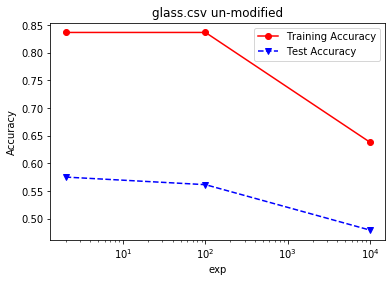

In [9]:
exp_experiment('glass.csv', normalise=False)

/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in double_scalars
/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in double_scalars


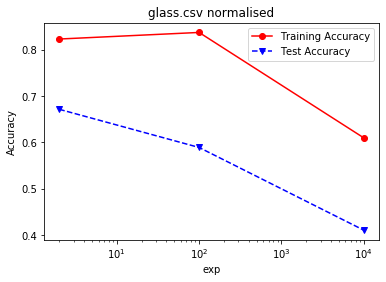

In [10]:
exp_experiment('glass.csv', normalise=True)

The exp experiment for the Glass dataset provides similar results with a higher accuracy rate for the normalised dataset.

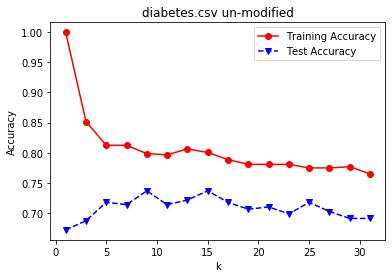

In [39]:
k_experiment('diabetes.csv', normalise=False)

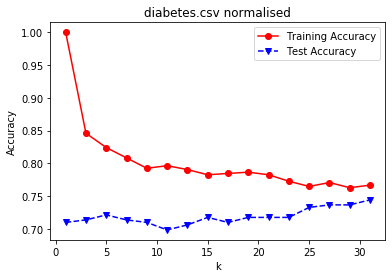

In [40]:
k_experiment('diabetes.csv', normalise=True)

We can see that the normalised data also performs better than the un-normalised data for the Diabetes dataset, especiallu at higher values of K.

/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in double_scalars


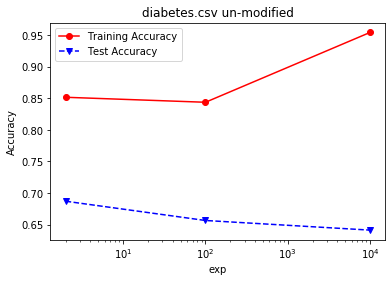

In [41]:
exp_experiment('diabetes.csv', normalise=False)

/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in double_scalars
/home/leon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in double_scalars


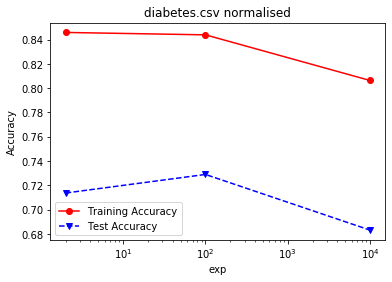

In [43]:
exp_experiment('diabetes.csv', normalise=True)

Interestingly the normalised values for the exp experiment provide a lower value for training accuracy at exp=10000, however the test accuracy is improved for the normalised data.

## Part C <a class="anchor" id="6"></a>

Add to class `kNN` method `get_class_probs` that computes for all the test instances in `X_test` the posterior class probabilities. This means that the method computes for each row (instance) in `X_test` a row with probability of class 1, probability of class 2, and probability of class $n$. Combine the rows of the posterior class probabilities in `pandas.DataFrame` object that will be the output of the method `get_class_probs`.

In [24]:
data = pd.read_csv('glass.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

clf = kNN()
clf.fit(X_train, Y_train)
clf.get_class_probs(X_test)

,'build wind non-float','build wind float',headlamps,'vehic wind float',containers,tableware
0,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.666667,0.000000,0.333333,0.000000
3,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000
4,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
68,0.000000,0.333333,0.000000,0.666667,0.000000,0.000000
69,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000
70,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333
71,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Part D <a class="anchor" id="7"></a>

Add to class kNN method `get_prediction` that computes for all the test instances in  `X_test`  regression  values  for  the  output  attribute.  This  means  that  the  method computes for each instance (row) in `X_test` a regression value equal to the average of  y  values  in  `Y_train`  of  the  $k$-nearest  neighbors  of  the  instance  in  `X_train`. Combine  the  computed  regression  values  for  all  the  instances  in  `X_test`  in `pandas.DataFrame` object that will be the output of the method `get_prediction`. 

Test the method `get_prediction` on the autoprice data set which is a regression data set (see Appendix A). For that purpose you can adapt the test script that you have already  used  for  Task  B.  Please  use  mean  absolute  error  as  the  main  metric  for estimating regression performance instead of the accuracy rate. To compute the mean absolute error you can use method `mean_absolute_error`  from `sklearn.metrics`.

In [36]:
def regression(csv_file_name):

    data = pd.read_csv(csv_file_name)
    data.head()
    Y = data['class']
    X = data.drop(['class'],axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

    k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

    trainAcc = np.zeros(len(k_range))
    testAcc = np.zeros(len(k_range))

    index = 0 
    for k  in  k_range:
        clf = kNN(k)
        clf.fit(X_train, Y_train)
        Y_predTrain = clf.get_predictions(X_train)
        Y_predTest = clf.get_predictions(X_test)
        trainAcc[index] = mean_absolute_error(Y_train, Y_predTrain)
        testAcc[index] = mean_absolute_error(Y_test, Y_predTest)
        index += 1

    plt.plot(k_range,trainAcc,'ro-',k_range,testAcc,'bv--')
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.xlabel('k')
    plt.ylabel('Accuracy')

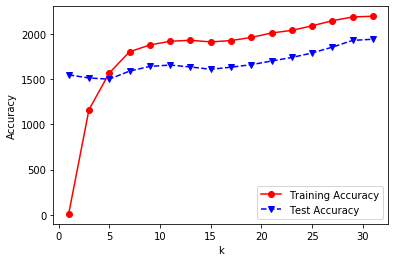

In [38]:
regression('autoprice.csv')